In [236]:
# importando as bibliotecas necessárias
import pandas as pd # manipulação de datasets
import numpy as np  # operações matemáticas 

# sklearn testagem
from sklearn.preprocessing import minmax_scale
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.utils import shuffle

#sklearn metricas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score

#Filters
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from ReliefF import ReliefF
from mrmr import mrmr_classif

#Modelos
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgb

# biblioteca para visualização
import matplotlib.pyplot as plt
import seaborn as sns

#utility
from multiprocessing import Process, Pool
from tqdm import tqdm
import time
import pickle
import pyarrow.parquet as pq

In [6]:
data_list = []
list_tests = ['Bladder_GSE31189.csv',     
            'Gastric_GSE19826.csv',      
            'Prostate_GSE6919_U95B.csv',
            'Brain_GSE50161.csv',       
            'Leukemia_GSE28497.csv',     
            'Renal_GSE53757.csv',
            'Breast_GSE70947.csv',      
            'Liver_GSE14520_U133A.csv',  
            'Throat_GSE42743.csv',
            'Colorectal_GSE44076.csv',  
            'Lung_GSE19804.csv',           
            'Ovary_GSE6008.csv',]

print('Conjuntos de dados:', len(list_tests))
for test in tqdm(list_tests):
    data_list.append(pd.read_csv('Data/'+test, index_col = 0))

Conjuntos de dados: 12


100%|██████████| 12/12 [01:03<00:00,  5.31s/it]


In [7]:
dicts = [
        {'ependymoma':1, 'glioblastoma':2, 'medulloblastoma':3, 'normal':0,'pilocytic_astrocytoma':4},
        {'primary_breast_cancer':1, 'normal':0},
        {'breast_cancer_mixed':1, 'breast_cancer_dcis':2, 'breast_cancer_idc':3, 'normal':0},
        {'normal':0, 'tumoral':1},
        {'basal': 1, 'HER': 2, 'cell_line': 3, 'normal':0, 'luminal_A':4, 'luminal_B':5},
        {'normal':0, 'breast_adenocarcinoma':1},
        {'tumoral_LCM':1, 'normal_homogenized':0, 'tumoral_homogenized':2},
        {'normal':0, 'adenocarcinoma':1},
        {'B-CELL_ALL':0, 'B-CELL_ALL_TCF3-PBX1':1, 'B-CELL_ALL_HYPERDIP':2, 'B-CELL_ALL_HYPO':3, 'B-CELL_ALL_MLL':4, 'B-CELL_ALL_T-ALL':5,'B-CELL_ALL_ETV6-RUNX1':6},
        {'normal':0, 'HCC':1},
        {'normal':0, 'HCC':1},
        {'primary_prostate_tumor':1, 'normal':0},
        {'primary_prostate_tumor':1, 'normal':0},
        {'ccRCC':1, 'normal':0}
        ]

samples
124    tumoral_urothelia
125    tumoral_urothelia
126    tumoral_urothelia
127    tumoral_urothelia
128    tumoral_urothelia
             ...        
209     normal_urothelia
211     normal_urothelia
212     normal_urothelia
213     normal_urothelia
215     normal_urothelia
Name: type, Length: 85, dtype: object

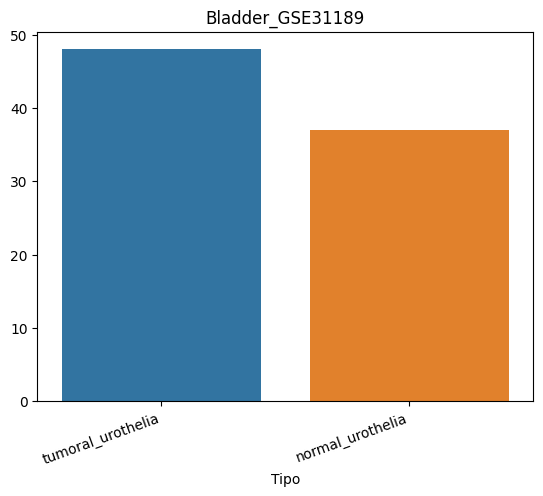

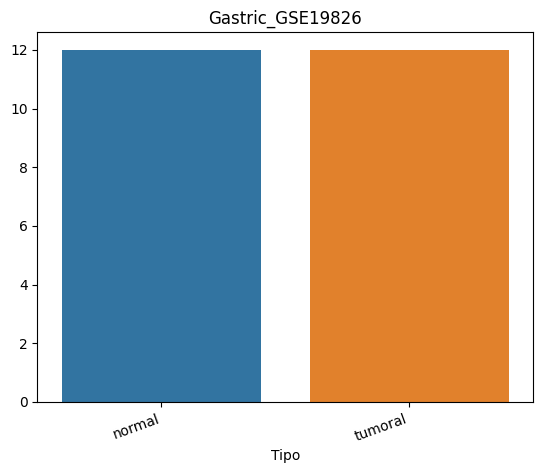

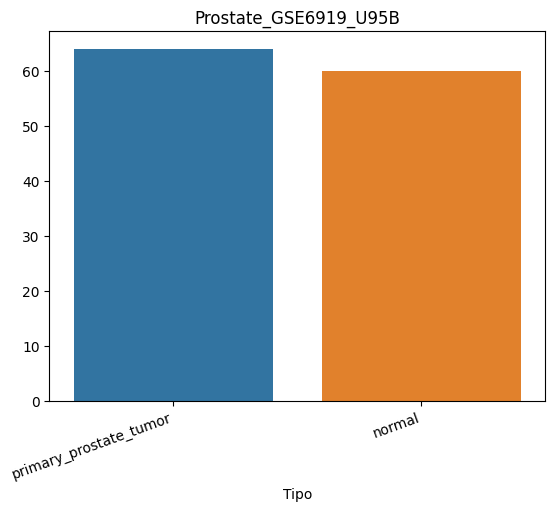

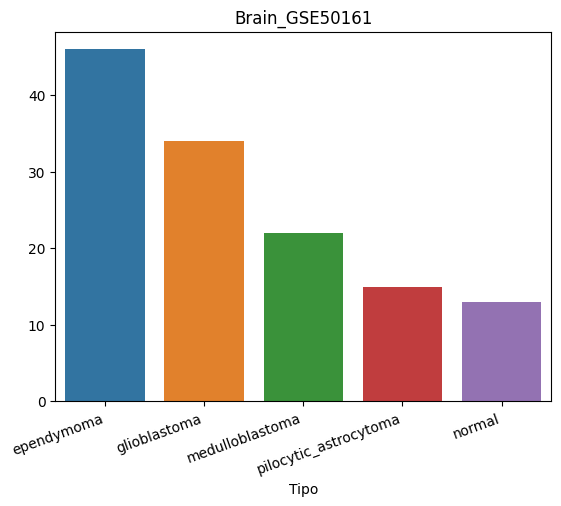

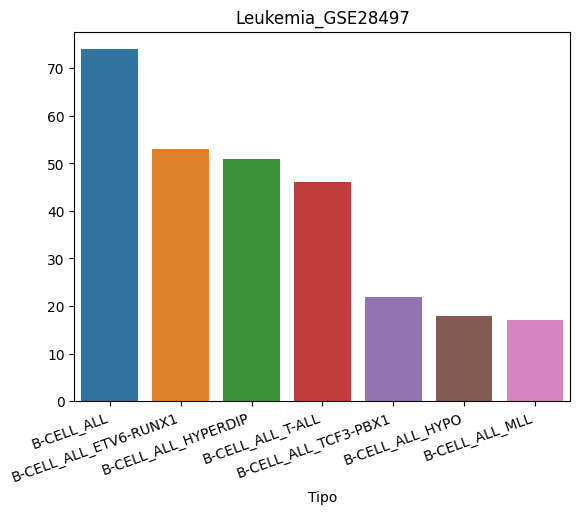

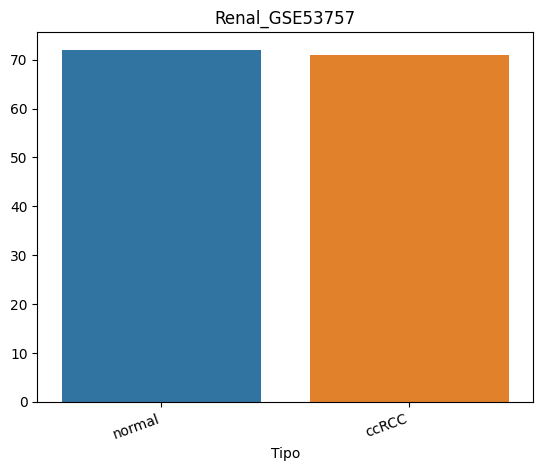

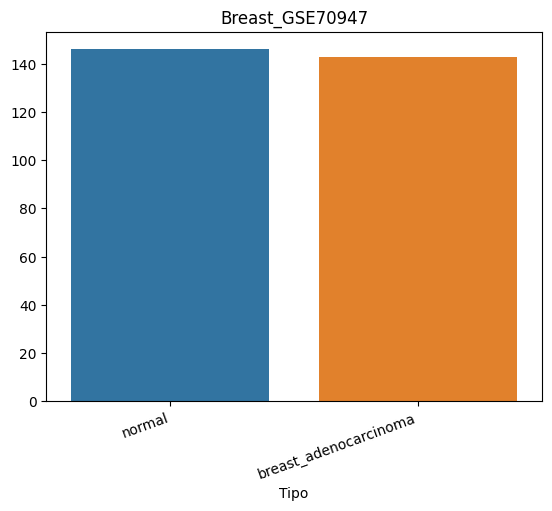

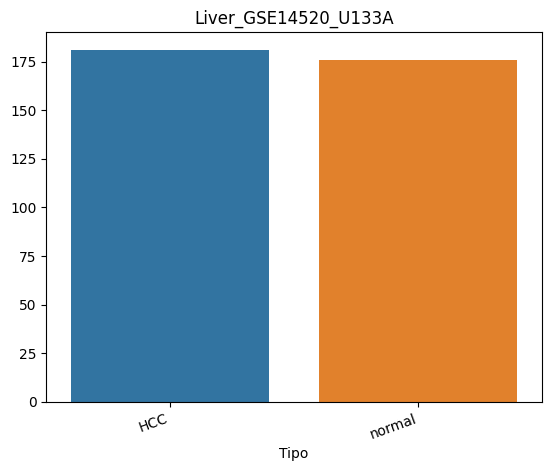

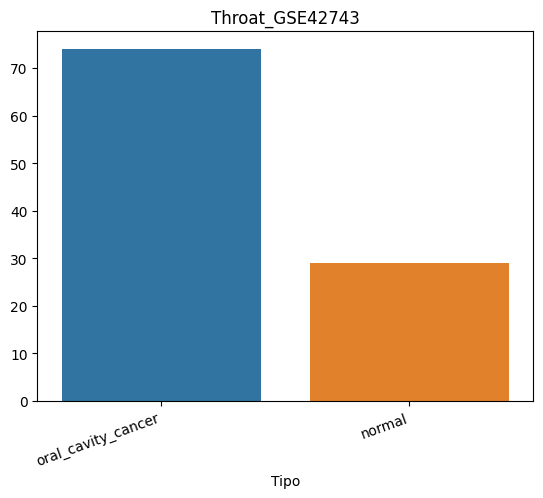

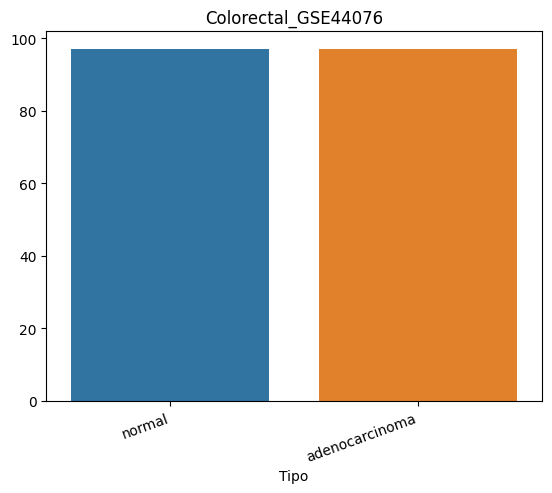

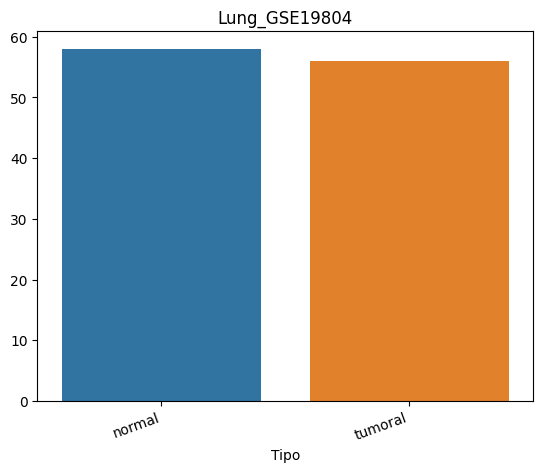

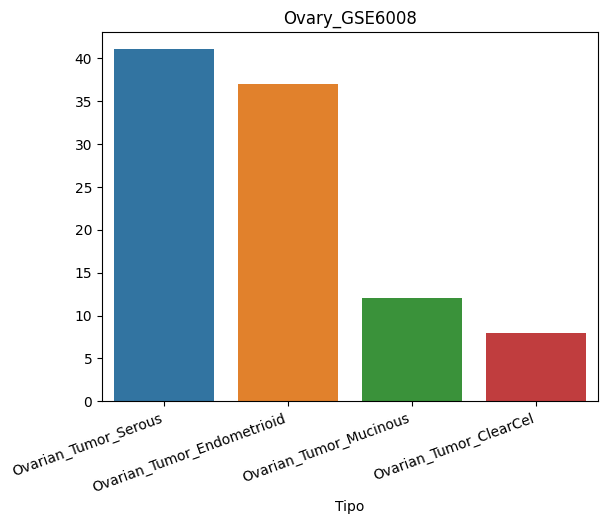

In [263]:
i = 0
for data, name in zip(data_list, list_tests):
    sns.barplot(y=data.iloc[:,0].value_counts().values, x=data.iloc[:,0].value_counts().index, hue =data.iloc[:,0].value_counts().index)
    plt.xticks(rotation=20, ha='right')
    plt.xlabel('Tipo')
    plt.title(name.replace('.csv', ''))
    plt.show()

In [92]:
for data in data_list:
    print(data.iloc[:,0].unique())

['tumoral_urothelia' 'normal_urothelia']
['normal' 'tumoral']
['primary_prostate_tumor' 'normal']
['ependymoma' 'glioblastoma' 'medulloblastoma' 'normal'
 'pilocytic_astrocytoma']
['B-CELL_ALL' 'B-CELL_ALL_TCF3-PBX1' 'B-CELL_ALL_HYPERDIP'
 'B-CELL_ALL_HYPO' 'B-CELL_ALL_MLL' 'B-CELL_ALL_T-ALL'
 'B-CELL_ALL_ETV6-RUNX1']
['ccRCC' 'normal']
['normal' 'breast_adenocarcinoma']
['HCC' 'normal']
['oral_cavity_cancer' 'normal']
['normal' 'adenocarcinoma']
['tumoral' 'normal']
['Ovarian_Tumor_ClearCel' 'Ovarian_Tumor_Endometrioid'
 'Ovarian_Tumor_Mucinous' 'Ovarian_Tumor_Serous']


In [120]:
dicts= [{'tumoral_urothelia':1,'normal_urothelia':0},
        {'normal':0,'tumoral':1},
        {'primary_prostate_tumor':1,'normal':0},
        {'ependymoma':2,'glioblastoma':3,'medulloblastoma':4,'normal':0
        ,'pilocytic_astrocytoma':1},
        {'B-CELL_ALL':0,'B-CELL_ALL_TCF3-PBX1':1,'B-CELL_ALL_HYPERDIP':2
        ,'B-CELL_ALL_HYPO':3,'B-CELL_ALL_MLL':4,'B-CELL_ALL_T-ALL':5,'B-CELL_ALL_ETV6-RUNX1':6},
        {'ccRCC':1,'normal':0},
        {'normal':0,'breast_adenocarcinoma':1},
        {'HCC':1,'normal':0},
        {'oral_cavity_cancer':1,'normal':0},
        {'normal':0,'adenocarcinoma':1},
        {'tumoral':1,'normal':0},
        {'Ovarian_Tumor_ClearCel':0,'Ovarian_Tumor_Endometrioid':1,'Ovarian_Tumor_Mucinous':2,'Ovarian_Tumor_Serous':3}]
X_list = []
y_list = []
for dict,data in zip(dicts,data_list):
    y_list.append(data.iloc[:,0].replace(dict))
    data.columns = list(map(lambda x: x.replace(':',''), list(data.columns)))
    X_list.append(data.iloc[:,1:])

In [127]:
def normaliza(df):
    for coluna in tqdm(df.columns):
        df[coluna] = (df[coluna] - df[coluna].mean())/np.std(df[coluna])
    return df

if __name__ == '__main__':
    with Pool(12) as p:
        result = p.map(normaliza, X_list) 
for r, r_ in zip(result, X_lista):
    print(r.shape, r_.shape)
    
X_list = result


100%|██████████| 49386/49386 [15:38<00:00, 52.63it/s] 


(85, 54675) (85, 54675)
(24, 54675) (24, 54675)
(124, 12620) (124, 12620)
(130, 54675) (130, 54675)
(281, 22283) (281, 22283)
(143, 54675) (143, 54675)
(289, 35981) (289, 35981)
(357, 22277) (357, 22277)
(103, 54675) (103, 54675)
(194, 49386) (194, 49386)
(114, 54675) (114, 54675)
(98, 22283) (98, 22283)


In [149]:
pickle.dump(X_list, open('Data/Data_normalized.pkl', 'wb'))

### Dataframe de resultados 

In [240]:
result_dataframe = pd.DataFrame(columns=['Dataset', 'Method', 'n_features', 'cv', 'Accuracy', 'F1'])

### Sem seleção de features

In [241]:
n_features = 10

for X, y, test in tqdm(zip(X_list, y_list, list_tests)):
    skf = StratifiedKFold(n_splits=10)
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        start = time.time()

        model_svm = LinearSVC(dual="auto")
        model_svm.fit(X.iloc[train_index], y.iloc[train_index])
        y_pred = model_svm.predict(X.iloc[test_index])
        end = time.time()
        
        new = pd.DataFrame.from_dict({'Dataset': test, 
                                'Method':'No selection',
                                'n_features':[n_features],
                                'cv':[i],
                                'Accuracy':accuracy_score(y.iloc[test_index], y_pred),
                                'F1':f1_score(y.iloc[test_index], y_pred, average='macro'),
                                'Tempo': end-start})
        result_dataframe = pd.concat([result_dataframe,new],ignore_index=True)

12it [04:43, 23.66s/it]


### Gerando seleção de feature e testes com Random Forest

In [242]:
n_features = 15

for X, y, test in tqdm(zip(X_list, y_list, list_tests)):
    skf = StratifiedKFold(n_splits=10)
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        start = time.time()
        model_fs = RandomForestClassifier()
        model_fs.fit(X.iloc[train_index], y.iloc[train_index])
        
        feature_names = X.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': model_fs.feature_importances_})
        features_selected = importance_df.sort_values(by='Importance', ascending = False).head(n_features)['Feature']
        
        #print(accuracy_score(model_fs.predict(X.iloc[test_index]),y.iloc[test_index]))
        model_svm = LinearSVC(dual="auto")
        model_svm.fit(X[features_selected].iloc[train_index], y.iloc[train_index])
        y_pred = model_svm.predict(X[features_selected].iloc[test_index])
        end = time.time()
        new = pd.DataFrame.from_dict({'Dataset': test, 
                                'Method':'Random Forest',
                                'n_features':[n_features],
                                'cv':[i],
                                'Accuracy':accuracy_score(y.iloc[test_index], y_pred),
                                'F1':f1_score(y.iloc[test_index], y_pred, average='macro'),
                                'Tempo': end-start})
        result_dataframe = pd.concat([result_dataframe,new],ignore_index=True)

12it [02:19, 11.65s/it]


### Seleção com LGBM

In [253]:
n_features = 15

for X, y, test in tqdm(zip(X_list, y_list, list_tests)):
    skf = StratifiedKFold(n_splits=10)
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        start = time.time()
        model_fs = lgb.LGBMClassifier(verbosity = -1)
        model_fs.fit(X.iloc[train_index], y.iloc[train_index])
        
        feature_names = X.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': model_fs.feature_importances_})
        features_selected = importance_df.sort_values(by='Importance', ascending = False).head(n_features)['Feature']
        
        #print(accuracy_score(model_fs.predict(X.iloc[test_index]),y.iloc[test_index]))
        model_svm = SVC()
        model_svm.fit(X[features_selected].iloc[train_index], y.iloc[train_index])
        y_pred = model_svm.predict(X[features_selected].iloc[test_index])
        
        end = time.time()
        new = pd.DataFrame.from_dict({'Dataset': test, 
                                'Method':'LGBM',
                                'n_features':[n_features],
                                'cv':[i],
                                'Accuracy':accuracy_score(y.iloc[test_index], y_pred),
                                'F1':f1_score(y.iloc[test_index], y_pred, average='macro'),
                                'Tempo': end-start})
        result_dataframe = pd.concat([result_dataframe,new],ignore_index=True)

12it [20:13, 101.14s/it]


### Filter Chi²

In [255]:

for X, y, test in tqdm(zip(X_list, y_list, list_tests)):
    skf = StratifiedKFold(n_splits=10)
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        start = time.time()
        filter = SelectKBest(chi2, k=n_features).fit(minmax_scale(X.iloc[train_index])
                                                     ,y.iloc[train_index])
        features_selected = filter.get_feature_names_out(X.columns)
        
        model_svm = SVC()
        model_svm.fit(X[features_selected].iloc[train_index], y.iloc[train_index])
        y_pred = model_svm.predict(X[features_selected].iloc[test_index])
        
        end = time.time()
        new = pd.DataFrame.from_dict({'Dataset': test, 
                                'Method':'Filter Chi²',
                                'n_features':[n_features],
                                'cv':[i],
                                'Accuracy':accuracy_score(y.iloc[test_index], y_pred),
                                'F1':f1_score(y.iloc[test_index], y_pred, average='macro'),
                                'Tempo': end-start})
        result_dataframe = pd.concat([result_dataframe,new],ignore_index=True)


12it [00:44,  3.68s/it]


### Filter ANOVA (F_classif)

In [256]:
for X, y, test in tqdm(zip(X_list, y_list, list_tests)):
    skf = StratifiedKFold(n_splits=10)
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        start = time.time()
        anova_filter = SelectKBest(f_classif, k=n_features)
        clf = LinearSVC(dual="auto")
        
        model_svm = make_pipeline(anova_filter, clf)
        model_svm.fit(X.iloc[train_index], y.iloc[train_index])
        y_pred = model_svm.predict(X.iloc[test_index])

        end = time.time()
        new = pd.DataFrame.from_dict({'Dataset': test, 
                                'Method':'Filter ANOVA',
                                'n_features':[n_features],
                                'cv':[i],
                                'Accuracy':accuracy_score(y.iloc[test_index], y_pred),
                                'F1':f1_score(y.iloc[test_index], y_pred, average='macro'),
                                'Tempo': end-start})
        result_dataframe = pd.concat([result_dataframe,new],ignore_index=True)

12it [01:17,  6.42s/it]


### Filter mRMR

In [229]:
for X, y, test in tqdm(zip(X_list, y_list, list_tests)):
    skf = StratifiedKFold(n_splits=10)
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
       
        features_selected = mrmr_classif(X=X.iloc[train_index], y=y.iloc[train_index], K=n_features)
        
        model_svm = SVC()
        model_svm.fit(X[features_selected].iloc[train_index], y.iloc[train_index])
        y_pred = model_svm.predict(X[features_selected].iloc[test_index])
        
        new = pd.DataFrame.from_dict({'Dataset': test, 
                                'Method':'Filter mRMR',
                                'n_features':[n_features],
                                'cv':[i],
                                'Accuracy':accuracy_score(y.iloc[test_index], y_pred),
                                'F1':f1_score(y.iloc[test_index], y_pred, average='macro'),
                                'Tempo': end-start})
        result_dataframe = pd.concat([result_dataframe,new],ignore_index=True)

0it [09:33, ?it/s]

KeyboardInterrupt



In [243]:
result_dataframe

,Dataset,Method,n_features,cv,Accuracy,F1,Tempo
0,Bladder_GSE31189.csv,No selection,10,0,0.444444,0.307692,1.321664
1,Bladder_GSE31189.csv,No selection,10,1,0.444444,0.307692,1.420005
2,Bladder_GSE31189.csv,No selection,10,2,0.555556,0.500000,1.331733
3,Bladder_GSE31189.csv,No selection,10,3,0.555556,0.500000,1.299790
4,Bladder_GSE31189.csv,No selection,10,4,0.666667,0.649351,1.419959
...,...,...,...,...,...,...,...
235,Ovary_GSE6008.csv,Random Forest,15,5,0.700000,0.737500,0.637135
236,Ovary_GSE6008.csv,Random Forest,15,6,0.800000,0.791667,0.652832
237,Ovary_GSE6008.csv,Random Forest,15,7,0.600000,0.598485,0.643741
238,Ovary_GSE6008.csv,Random Forest,15,8,0.777778,0.740741,0.644575


In [258]:
print(result_dataframe[result_dataframe['Method'] == 'Random Forest']['F1'].mean())
print(result_dataframe[result_dataframe['Method'] == 'LGBM']['F1'].mean())
print(result_dataframe[result_dataframe['Method'] == 'Filter Chi²']['F1'].mean())
print(result_dataframe[result_dataframe['Method'] == 'Filter ANOVA']['F1'].mean())
print(result_dataframe[result_dataframe['Method'] == 'No selection']['F1'].mean())

0.7774485333691357
0.7822977719598146
0.7835212998347392
0.7829191427909094
0.7164327069090337


In [257]:
result_dataframe.groupby(['Method', 'Dataset']).mean()

Accuracy        F1      Tempo
Method        Dataset                                                 
Filter ANOVA  Bladder_GSE31189.csv       0.508333  0.444273   0.791769
              Brain_GSE50161.csv         0.853846  0.826960   0.814984
              Breast_GSE70947.csv        0.855049  0.851819   0.649166
              Colorectal_GSE44076.csv    0.989737  0.989665   0.813255
              Gastric_GSE19826.csv       0.833333  0.806667   0.755598
              Leukemia_GSE28497.csv      0.676601  0.634954   0.380483
              Liver_GSE14520_U133A.csv   0.955238  0.955185   0.418124
              Lung_GSE19804.csv          0.955303  0.955093   0.825351
              Ovary_GSE6008.csv          0.591111  0.567659   0.324839
              Prostate_GSE6919_U95B.csv  0.664103  0.660021   0.191173
              Renal_GSE53757.csv         0.844286  0.843620   0.870962
              Throat_GSE42743.csv        0.883636  0.859113   0.816452
Filter Chi²   Bladder_GSE31189.csv       0.563889  0.490096   0.367584
              Brain_GSE50161.csv         0.784615  0.671473   0.439833
              Breast_GSE70947.csv        0.813424  0.805900   0.433343
              Colorectal_GSE44076.csv    0.984211  0.984093   0.494815
              Gastric_GSE19826.csv       0.900000  0.900000   0.384469
              Leukemia_GSE28497.csv      0.675862  0.552447   0.220385
              Liver_GSE14520_U133A.csv   0.966429  0.966396   0.310533
              Lung_GSE19804.csv          0.973485  0.973116   0.457913
              Ovary_GSE6008.csv          0.662222  0.699314   0.135649
              Prostate_GSE6919_U95B.csv  0.712179  0.708864   0.147844
              Renal_GSE53757.csv         0.858571  0.857979   0.514009
              Throat_GSE42743.csv        0.855455  0.792580   0.441445
LGBM          Bladder_GSE31189.csv       0.494444  0.446310   8.381074
              Brain_GSE50161.csv         0.915385  0.883460  18.868905
              Breast_GSE70947.csv        0.851601  0.850089  13.576230
              Colorectal_GSE44076.csv    0.990000  0.989975  10.642736
              Gastric_GSE19826.csv       0.700000  0.625000   0.587877
              Leukemia_GSE28497.csv      0.829187  0.748868  23.979517
              Liver_GSE14520_U133A.csv   0.966508  0.966464  10.725914
              Lung_GSE19804.csv          0.965152  0.964841   9.552723
              Ovary_GSE6008.csv          0.703333  0.642314   3.386549
              Prostate_GSE6919_U95B.csv  0.623077  0.612837   1.054267
              Renal_GSE53757.csv         0.829524  0.829110  10.857452
              Throat_GSE42743.csv        0.884545  0.828305   9.706821
No selection  Bladder_GSE31189.csv       0.516667  0.434352   1.377860
              Brain_GSE50161.csv         0.730769  0.751254   5.183294
              Breast_GSE70947.csv        0.906773  0.905609   5.459149
              Colorectal_GSE44076.csv    0.989737  0.989665   4.010339
              Gastric_GSE19826.csv       0.816667  0.800000   0.644244
              Leukemia_GSE28497.csv      0.548522  0.625883   6.424777
              Liver_GSE14520_U133A.csv   0.966429  0.966374   0.709619
              Lung_GSE19804.csv          0.946970  0.946659   0.987664
              Ovary_GSE6008.csv          0.313333  0.303214   0.687046
              Prostate_GSE6919_U95B.csv  0.616667  0.597586   0.346604
              Renal_GSE53757.csv         0.851429  0.851175   1.348815
              Throat_GSE42743.csv        0.451818  0.425421   1.119177
Random Forest Bladder_GSE31189.csv       0.577778  0.516863   0.881072
              Brain_GSE50161.csv         0.838462  0.816752   1.191311
              Breast_GSE70947.csv        0.834483  0.831826   2.341433
              Colorectal_GSE44076.csv    0.989737  0.989665   0.971559
              Gastric_GSE19826.csv       0.716667  0.700000   0.465459
              Leukemia_GSE28497.csv      0.764778  0.662264   2.083701
              Liver_GSE14520_U133A.csv   0.957857  0.957796   1.8